# Will weather conditions effect distance?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
from string import punctuation

In [2]:
class DataParser:
    """

    This class implements a parser that cleans the variables of the NFL dataset
    for the 2019 NFL data competition held on Kaggle.

    Parameters
    ----------
    data: the nfl data in pandas DataFrame format

    Notes
    -----
    Might not work if some of the columns have been edited since initial
    import. In that case, either implement additional feature engineering
    methods or reload the data.

    References
    ----------
    The methods were implemented based from the one found at:
    https://www.kaggle.com/prashantkikani/nfl-starter-lgb-feature-engg
    https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win

    """

    def __init__(self, data):
        self.data = data

    def cleanWindSpeed(self, x):
        x = str(x)
        x = x.lower()
        if '-' in x:
            x = (int(x.split('-')[0]) + int(x.split('-')[1])) / 2
        elif ' gusts up to 25 ' in x:
            x = (int(x.split(' gusts up tp 25 ')))
        try:
            return float(x)
        except:
            return -1

    def cleanGameWeather(self, x):
        x = str(x).lower()
        if 'sunny' in x or 'clear' in x or 'fair' in x:
            return 'sunny'
        elif 'cloud' in x or 'coudy' in x or 'clouidy' in x or 'hazy' in x or 'sun & clouds' in x or 'overcast' in x:
            return 'cloudy'
        elif 'rain' in x or 'shower' in x or 'rainy' in x:
            return 'rainy'
        elif 'controlled climate' in x or 'indoor' in x:
            return 'indoor'
        elif 'snow' in x:
            return 'snowy'
        return None

    def mapGameWeather(self, txt):
        """
        Creates the following map: indoor=>3, sunny=>2, cloudy=>1, rainy=>-2, snowy=>-3
        """
        ans = 1
        if pd.isna(txt):
            return 0
        if 'indoor' in txt:
            return ans*3
        if 'sunny' in txt or 'sunny' in txt:
            return ans*2
        if 'cloudy' in txt:
            return ans
        if 'rainy' in txt or 'rainy' in txt:
            return -2*ans
        if 'snowy' in txt:
            return -3*ans
        return 0

    def cleanStadiumType(self, txt):  # Fixes the typo
        if pd.isna(txt):
            return np.nan
        txt = txt.lower()
        txt = ''.join([c for c in txt if c not in punctuation])
        txt = re.sub(' +', ' ', txt)
        txt = txt.strip()
        txt = txt.replace('outside', 'outdoor')
        txt = txt.replace('outdor', 'outdoor')
        txt = txt.replace('outddors', 'outdoor')
        txt = txt.replace('outdoors', 'outdoor')
        txt = txt.replace('oudoor', 'outdoor')
        txt = txt.replace('indoors', 'indoor')
        txt = txt.replace('ourdoor', 'outdoor')
        txt = txt.replace('retractable', 'rtr.')
        return txt

    # Focuses only on the words: outdoor, indoor, closed and open.
    def cleanStadiumType2(self, txt):
        if pd.isna(txt):
            return np.nan
        if 'outdoor' in txt or 'open' in txt:
            return 1
        if 'indoor' in txt or 'closed' in txt:
            return 0
        return np.nan

    def cleanDefencePersonnel(self):
        arr = [[int(s[0]) for s in t.split(', ')]
               for t in self.data['DefensePersonnel']]
        self.data['DL'] = pd.Series([int(a[0]) for a in arr])
        self.data['LB'] = pd.Series([int(a[1]) for a in arr])
        self.data['DB'] = pd.Series([int(a[2]) for a in arr])
        self.data = self.data.drop(labels=["DefensePersonnel"], axis=1)

    def cleanOffencePersonnel(self):
        arr = [[int(s[0]) for s in t.split(", ")]
               for t in self.data["OffensePersonnel"]]
        self.data["RB"] = pd.Series([int(a[0]) for a in arr])
        self.data["TE"] = pd.Series([int(a[1]) for a in arr])
        self.data["WR"] = pd.Series([int(a[2]) for a in arr])
        self.data = self.data.drop(labels=["OffensePersonnel"], axis=1)

    def cleanHeight(self):
        """
        Parses the PlayerHeight column and converts height into inches
        """
        self.data['PlayerHeight'] = self.data['PlayerHeight'].apply(
            lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

    def cleanTimeHandoff(self):
        self.data['TimeHandoff'] = self.data['TimeHandoff'].apply(
            lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

    def cleanTimeSnap(self):
        self.data['TimeSnap'] = self.data['TimeSnap'].apply(
            lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

    def cleanGameClock(self):
        arr = [[int(s[0]) for s in t.split(":")]
               for t in self.data["GameClock"]]
        self.data["GameHour"] = [int(a[0]) for a in arr]
        self.data["GameMinute"] = [int(a[1]) for a in arr]
        self.data = self.data.drop(labels=['GameClock'], axis=1)

    def cleanTurf(self):
        # from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087
        Turf = {'Field Turf': 'Artificial', 'A-Turf Titan': 'Artificial', 'Grass': 'Natural', 'UBU Sports Speed S5-M': 'Artificial',
                'Artificial': 'Artificial', 'DD GrassMaster': 'Artificial', 'Natural Grass': 'Natural',
                'UBU Speed Series-S5-M': 'Artificial', 'FieldTurf': 'Artificial', 'FieldTurf 360': 'Artificial', 'Natural grass': 'Natural', 'grass': 'Natural',
                'Natural': 'Natural', 'Artifical': 'Artificial', 'FieldTurf360': 'Artificial', 'Naturall Grass': 'Natural', 'Field turf': 'Artificial',
                'SISGrass': 'Artificial', 'Twenty-Four/Seven Turf': 'Artificial', 'natural grass': 'Natural'}

        self.data['Turf'] = self.data['Turf'].map(Turf)
        self.data['Turf'] = self.data['Turf'] == 'Natural'

    def cleanPossessionTeam(self):  # fixes problem in team name encoding
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in self.data['PossessionTeam'].unique():
            map_abbr[abb] = abb
        self.data['PossessionTeam'] = self.data['PossessionTeam'].map(
            map_abbr)
        self.data['HomeTeamAbbr'] = self.data['HomeTeamAbbr'].map(map_abbr)
        self.data['VisitorTeamAbbr'] = self.data['VisitorTeamAbbr'].map(
            map_abbr)

    def cleanPlayerBirthDate(self):
        self.data['PlayerBirthDate'] = self.data['PlayerBirthDate'].apply(
            lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

    def cleanWindDirection(self, txt):
        if pd.isna(txt):
            return np.nan
        txt = txt.lower()
        txt = ''.join([c for c in txt if c not in punctuation])
        txt = txt.replace('from', '')
        txt = txt.replace(' ', '')
        txt = txt.replace('north', 'n')
        txt = txt.replace('south', 's')
        txt = txt.replace('west', 'w')
        txt = txt.replace('east', 'e')
        return txt

    def cleanWindDirection2(self, txt):
        if pd.isna(txt):
            return np.nan
        if txt == 'n':
            return 0
        if txt == 'nne' or txt == 'nen':
            return 1/8
        if txt == 'ne':
            return 2/8
        if txt == 'ene' or txt == 'nee':
            return 3/8
        if txt == 'e':
            return 4/8
        if txt == 'ese' or txt == 'see':
            return 5/8
        if txt == 'se':
            return 6/8
        if txt == 'ses' or txt == 'sse':
            return 7/8
        if txt == 's':
            return 8/8
        if txt == 'ssw' or txt == 'sws':
            return 9/8
        if txt == 'sw':
            return 10/8
        if txt == 'sww' or txt == 'wsw':
            return 11/8
        if txt == 'w':
            return 12/8
        if txt == 'wnw' or txt == 'nww':
            return 13/8
        if txt == 'nw':
            return 14/8
        if txt == 'nwn' or txt == 'nnw':
            return 15/8
        return np.nan

    def cleanPlayDirection(self):
        """
        1 if play direction if right, 0 if play direction is left.
        """
        self.data['PlayDirection'] = self.data['PlayDirection'].apply(
            lambda x: x.strip() == 'right')

    def cleanTeam(self):
        """
        1 if home team, 0 if away team
        """
        self.data['Team'] = self.data['Team'].apply(
            lambda x: x.strip() == 'home')

    def parse(self):
        self.data['WindSpeed'] = self.data['WindSpeed'].apply(
            lambda p: self.cleanWindSpeed(p))
        self.data['GameWeather'] = self.data['GameWeather'].apply(
            lambda p: self.cleanGameWeather(p))
        self.data['GameWeather'] = self.data['GameWeather'].apply(
            self.mapGameWeather)
        self.data['StadiumType'] = self.data['StadiumType'].apply(
            self.cleanStadiumType)
        self.data['StadiumType'] = self.data['StadiumType'].apply(
            self.cleanStadiumType2)
        self.data['WindDirection'] = self.data['WindDirection'].apply(
            self.cleanWindDirection)
        self.data['WindDirection'] = self.data['WindDirection'].apply(
            self.cleanWindDirection2)
        self.cleanOffencePersonnel()
        self.cleanDefencePersonnel()
        self.cleanHeight()
        self.cleanTimeHandoff()
        self.cleanTimeSnap()
        self.cleanTurf()
        self.cleanPossessionTeam()
        self.cleanPlayerBirthDate()
        self.cleanPlayDirection()
        self.cleanTeam()

        return self.data

In [3]:
class FeatureEngine:
    """A Feature Engineer for the NFL data

    This class implements an engine that engineers
    the variables of the NFL dataset for the 2019 NFL data competition held on Kaggle.

    Parameters
    ----------
    data: the nfl data in pandas DataFrame format

    exclude: A list of feature engineering processes to exclude

    Notes
    -----
    Might not work if some of the columns have been edited since initial
    import. In that case, either implement additional feature engineering
    methods or reload the data.

    References
    ----------
    The methods were implemented based from the one found at:
    https://www.kaggle.com/prashantkikani/nfl-starter-lgb-feature-engg
    https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
    """

    def __init__(self, data, exclude=[]):
        self.data = data  # Clean data from the parser
        self.exclude = exclude  # Pass a list of processes to exclude
        self.include = ['X',
                        'Orientation',
                        'HomeField',
                        'FieldEqPossession',
                        'isRusher',
                        'PlayerAge',
                        'HandSnapDelta',
                        'YardsLeft',
                        'BMI',
                        'DefendersInTheBox_vs_Distance']

    def engineerX(self):
        """
        Readjusts X
        """
        self.data['X'] = self.data.apply(
            lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)

    def engineerOrientation(self, angle, play_direction):
        """
        Readjusts Orientation

        References
        ----------
        #from https://www.kaggle.com/scirpus/hybrid-gp-and-nn
        """
        if play_direction == 0:
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def engineerFieldEqPossession(self):
        self.data['FieldEqPossession'] = self.data['FieldPosition'] == self.data['PossessionTeam']

    def engineerHomeField(self):
        self.data['HomeField'] = self.data['FieldPosition'] == self.data['HomeTeamAbbr']

    def engineerIsRusher(self):
        self.data['isRusher'] = self.data['NflId'] == self.data['NflIdRusher']
        self.data.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)

    def engineerHandoffSnapDelta(self):
        self.data['TimeDelta'] = self.data.apply(lambda row: (
            row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
        self.data = self.data.drop(['TimeHandoff', 'TimeSnap'], axis=1)

    def engineerYardsLeft(self):
        """
        Computes yards left from end-zone

        Note
        ----
        Requires variable HomeField (must execute engineerHomeField before execution)
        """
        self.data['YardsLeft'] = self.data.apply(
            lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
        self.data['YardsLeft'] = self.data.apply(
            lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)
        self.data.drop(self.data.index[(self.data['YardsLeft'] < self.data['Yards']) | (
            self.data['YardsLeft']-100 > self.data['Yards'])], inplace=True)

    def engineerBMI(self):
        """
        Computes the BMI of a player from height and weight
        """
        self.data['PlayerBMI'] = 703 * \
            (self.data['PlayerWeight']/(self.data['PlayerHeight'])**2)

    def engineerPlayerAge(self):
        """
        Computes the age of the player from TimeHandoff
        """
        seconds_in_year = 60*60*24*365.25
        self.data['PlayerAge'] = self.data.apply(lambda row: (
            row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
        self.data = self.data.drop(['PlayerBirthDate'], axis=1)

    def engineerDefendersInTheBox_vs_Distance(self):
        dfInBox_mode = self.data['DefendersInTheBox'].mode()
        self.data['DefendersInTheBox'].fillna(
            dfInBox_mode.iloc[0], inplace=True)
        self.data['DefendersInTheBox_vs_Distance'] = self.data['DefendersInTheBox'] / \
            self.data['Distance']

    ### Outputs clean and engineered DataFrame ###

    def engineer(self):
        for c in self.include:

            if c in self.exclude:
                continue

            elif c == 'X':
                self.engineerX

            elif c == 'Orientation':
                self.data['Orientation'] = self.data.apply(lambda row: self.engineerOrientation(
                    row['Orientation'], row['PlayDirection']), axis=1)
                self.data['Dir'] = self.data.apply(lambda row: self.engineerOrientation(
                    row['Dir'], row['PlayDirection']), axis=1)

            elif c == 'FieldEqPossession':
                self.engineerFieldEqPossession()

            elif c == 'HomeField':
                self.engineerHomeField()

            elif c == 'YardsLeft':
                self.engineerYardsLeft()

            elif c == 'isRusher':
                self.engineerIsRusher()

            elif c == 'PlayerAge':
                self.engineerPlayerAge()

            elif c == 'HandSnapDelta':
                self.engineerHandoffSnapDelta()

            elif c == 'BMI':
                self.engineerBMI()

            elif c == 'DefendersInTheBox_vs_Distance':
                self.engineerDefendersInTheBox_vs_Distance()

        return self.data

In [4]:
train = pd.read_csv('../data/train.csv')

/Users/shozendan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Parse Data
parser = DataParser(train)
train = parser.parse()

In [6]:
engine = FeatureEngine(train)
engine.engineer()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,LB,DB,HomeField,FieldEqPossession,isRusher,PlayerAge,TimeDelta,YardsLeft,PlayerBMI,DefendersInTheBox_vs_Distance
0,2017090700,20170907000118,False,73.91,34.84,1.69,1.13,0.40,278.01,182.82,...,3,6,True,True,False,28.692760,1.0,35,28.749228,3.000
1,2017090700,20170907000118,False,74.67,32.64,0.42,1.35,0.01,332.39,161.30,...,3,6,True,True,False,28.457305,1.0,35,35.993600,3.000
2,2017090700,20170907000118,False,74.00,33.20,1.22,0.59,0.31,356.99,157.27,...,3,6,True,True,False,28.629790,1.0,35,33.744000,3.000
3,2017090700,20170907000118,False,71.46,27.70,0.42,0.54,0.02,0.23,254.36,...,3,6,True,True,False,34.795430,1.0,35,30.619556,3.000
4,2017090700,20170907000118,False,69.32,35.42,1.82,2.43,0.16,347.37,195.69,...,3,6,True,True,False,30.061685,1.0,35,27.935571,3.000
5,2017090700,20170907000118,False,75.06,24.00,1.01,0.32,0.18,51.66,264.99,...,3,6,True,True,False,26.475101,1.0,35,32.351351,3.000
6,2017090700,20170907000118,False,74.11,16.64,1.11,0.83,0.02,2.77,37.41,...,3,6,True,True,False,25.311514,1.0,35,26.496727,3.000
7,2017090700,20170907000118,False,73.37,18.73,1.24,0.74,0.13,31.48,89.96,...,3,6,True,True,False,26.431295,1.0,35,26.172647,3.000
8,2017090700,20170907000118,False,56.63,26.90,0.26,1.86,0.28,15.30,304.69,...,3,6,True,True,False,27.512746,1.0,35,26.702703,3.000
9,2017090700,20170907000118,False,73.35,38.83,4.55,0.76,0.51,284.53,169.16,...,3,6,True,True,False,24.662644,1.0,35,26.715085,3.000


In [13]:
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Temperature,Humidity,WindSpeed,WindDirection,RB,TE,WR,DL,LB,DB
0,2017090700,20170907000118,False,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,63.0,77.0,8.0,1.25,1,1,3,2,3,6
1,2017090700,20170907000118,False,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,63.0,77.0,8.0,1.25,1,1,3,2,3,6
2,2017090700,20170907000118,False,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,63.0,77.0,8.0,1.25,1,1,3,2,3,6
3,2017090700,20170907000118,False,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,63.0,77.0,8.0,1.25,1,1,3,2,3,6
4,2017090700,20170907000118,False,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,63.0,77.0,8.0,1.25,1,1,3,2,3,6


In [14]:
train.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'DefendersInTheBox', 'PlayDirection',
       'TimeHandoff', 'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight',
       'PlayerBirthDate', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType', 'Turf',
       'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection',
       'RB', 'TE', 'WR', 'DL', 'LB', 'DB'],
      dtype='object')

In [33]:
weather_yard = train[['GameWeather', 'Yards']]

In [34]:
def mapGameWeather(x):
    if x == 3:
        return 'indoor'
    if x == 2:
        return 'sunny'
    if x == 1:
        return 'cloudy'
    if x == -2:
        return 'rainy'
    if x == -3:
        return 'snowy'
    return np.nan
weather_yard['GameWeather'] = weather_yard['GameWeather'].apply(lambda x: mapGameWeather(x))

/Users/shozendan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [35]:
weather_yard.GameWeather.unique()

array(['sunny', 'cloudy', 'indoor', nan, 'rainy', 'snowy'], dtype=object)

In [36]:
weather_yard[weather_yard.GameWeather == 'sunny']['Yards']

0         8
1         8
2         8
3         8
4         8
         ..
508525   -1
508526   -1
508527   -1
508528   -1
508529   -1
Name: Yards, Length: 186912, dtype: int64

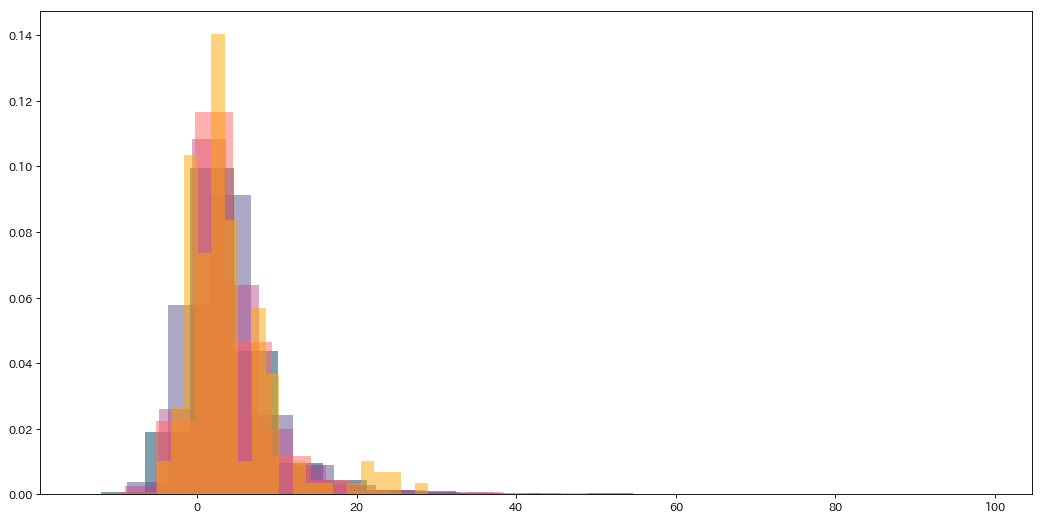

In [39]:
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
plt.figure(figsize=(16, 8), dpi=80)
for weather, color in zip(weather_yard.GameWeather.dropna().unique(), colors):
    plt.hist(weather_yard[weather_yard.GameWeather == weather]['Yards'], bins=20, color=color, alpha=.5, density=True)
plt.show()